In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

import scores

from polygon import get_polygon

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
""" 

    where am i?

"""

PATH = os.getcwd()
data_path = PATH.replace( '01_square_30', '' ) + 'data/01_square/01_square_1000000_30_5/raw/'

print( f'PATH: { PATH }' )
print( f'data_path: { data_path }' )

PATH: /Users/no_lineal/Documents/draft_code/grid_metrics/01_square_30
data_path: /Users/no_lineal/Documents/draft_code/grid_metrics/data/01_square/01_square_1000000_30_5/raw/


In [4]:
""" 

    load raw data

"""

res = np.load( data_path + 'res_999.npy', allow_pickle=True, encoding='latin1' )
res = dict( res.item() )

scores_btln = np.load( data_path + 'scores_999.npy', allow_pickle=True, encoding='latin1' )
scores_btln = dict( scores_btln.item() )

print( f'res: { res.keys() }' )
print( f'scores: { scores_btln.keys() }' )

res: dict_keys(['lstm', 'bottleneck', 'pos_xy'])
scores: dict_keys(['btln_60_separation', 'lstm_90', 'btln_60', 'btln_90_separation', 'btln_90', 'lstm_60'])


In [5]:
"""  

    build ratemap

"""

save = True

polygon_ = get_polygon( 'square', area=0.30**2, factor=1 )

res_pos = res['pos_xy']
res_btln = res['bottleneck']

print('')
print( f'sample_res_pos: { res_pos.shape }' )
print( f'sample_res_btln: { res_btln.shape }' )
print('')

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())

# coord range
min_x, min_y, max_x, max_y = polygon_.bounds
coord_range = ( (min_x, max_x), (min_y, max_y) )

res_ = 32
latest_epoch_scorer = scores.GridScorer( res_, coord_range, masks_parameters )

# concatenate trajectories
xy = res_pos.reshape(-1, res_pos.shape[-1])
act = res_btln.reshape(-1, res_btln.shape[-1])
n_units = act.shape[1]

# get ratemap for each unit
s = [ latest_epoch_scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i]) for i in tqdm(range(n_units)) ]

if save:
    np.save( data_path.replace('raw', 'grid_scores') + 'ratemap.npy', s )
    print( 'saved' )


sample_res_pos: (4000, 100, 2)
sample_res_btln: (4000, 100, 512)



100%|██████████| 512/512 [00:09<00:00, 52.93it/s]

saved


sample_idx: 3207


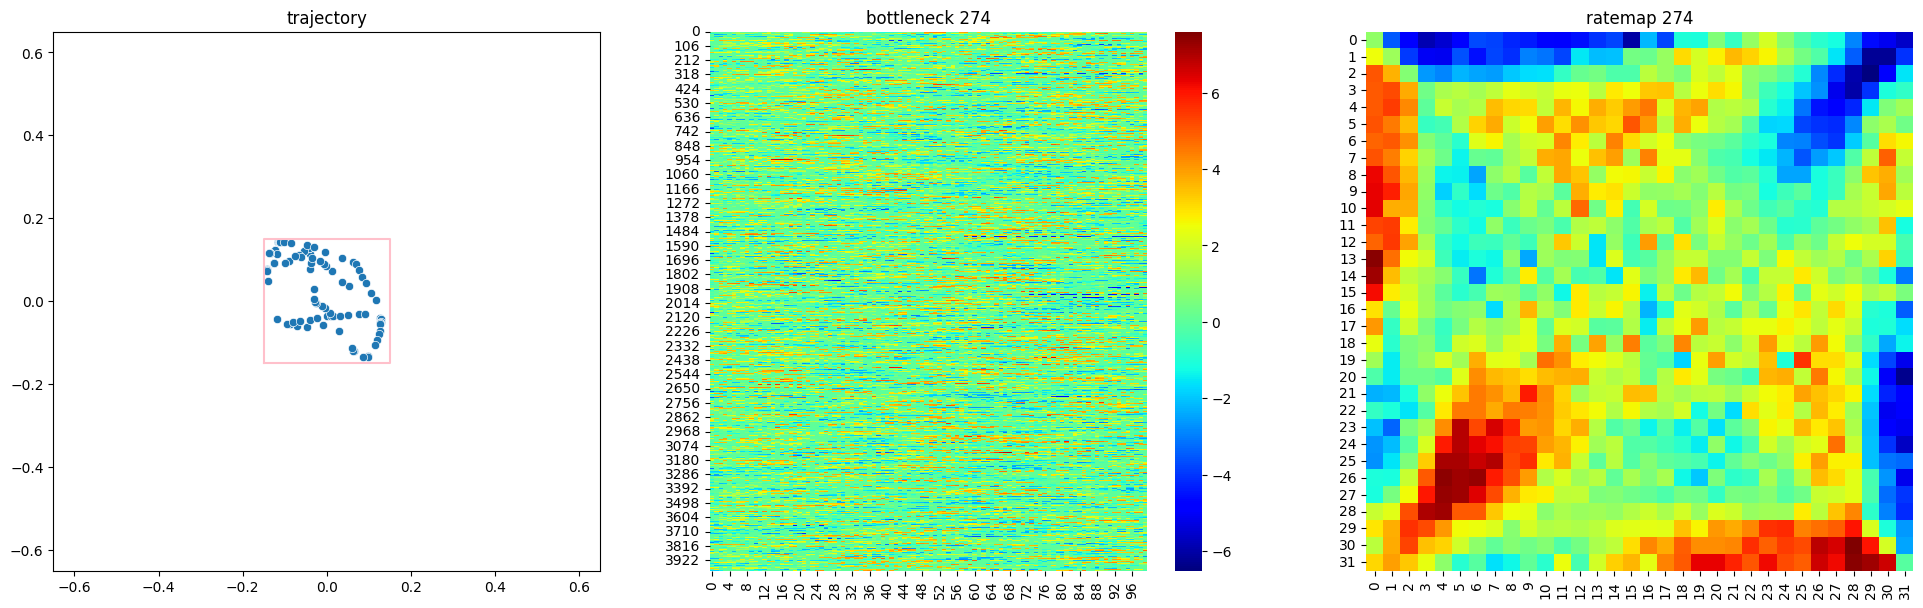

In [6]:
""" 

    viz

"""

sample_idx = np.random.randint( 0, res_pos.shape[0] )
print( f'sample_idx: { sample_idx }' )

fig, ax = plt.subplots( 1, 3, figsize=(24, 7))

sns.scatterplot( x=res_pos[sample_idx, :, 0], y=res_pos[sample_idx, :, 1], ax=ax[0] )
ax[0].set_xlim( min_x, max_x )
ax[0].set_ylim( min_y, max_y )
ax[0].set_title( 'trajectory' )

x, y = polygon_.exterior.xy
ax[0].plot( x, y, color='pink' )

ax[0].set_xlim( min_x - .5, max_x + .5 )
ax[0].set_ylim( min_y - .5, max_y + .5 )

sample_idx = np.random.randint( 0, len(s) )
sns.heatmap( res_btln[ :, :, sample_idx ], ax=ax[1], cmap='jet' )
ax[1].set_title( f'bottleneck { sample_idx }' )

sns.heatmap( s[ np.random.randint( sample_idx ) ], ax=ax[2], cmap='jet', cbar=False )
ax[2].set_title( f'ratemap { sample_idx }' )

plt.show()